In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)
%matplotlib inline

In [14]:
# select the image id (valid values 1,2,3, or 4)
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

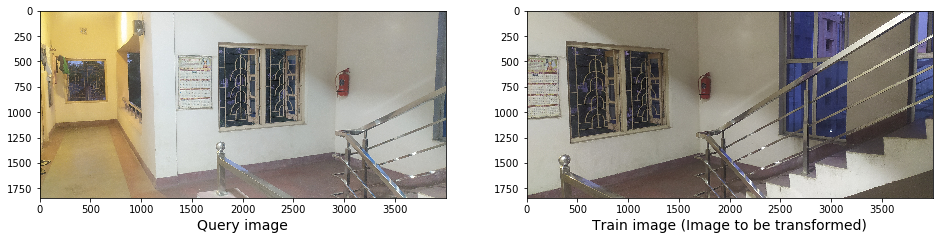

In [54]:
trainImg = imageio.imread("/home/srijan/Downloads/vb2.jpg")
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread("/home/srijan/Downloads/vb1.jpg")
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [55]:
descriptor = cv2.ORB_create()
kpsA, featuresA = descriptor.detectAndCompute(trainImg_gray, None)
kpsB, featuresB = descriptor.detectAndCompute(queryImg_gray, None)

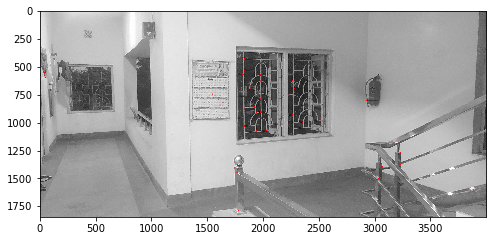

In [56]:
plt.figure(figsize=(8,8))
plt.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(255,0,0)))

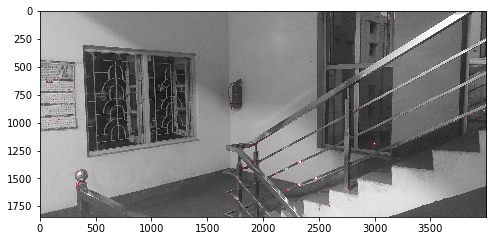

In [57]:
plt.figure(figsize=(8,8))
plt.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(255,0,0)))

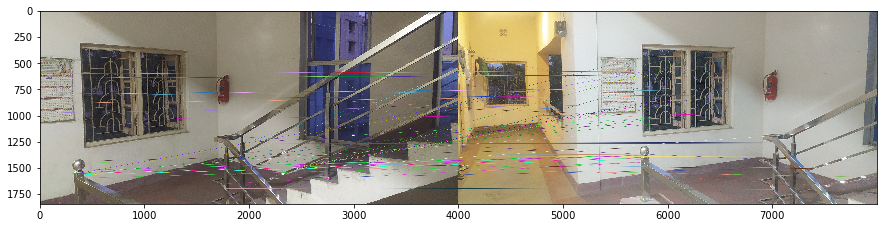

In [58]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
best_matches = bf.match(featuresA,featuresB)
rawMatches = sorted(best_matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,rawMatches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15,15))
plt.imshow(img3)

In [59]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [60]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, rawMatches, reprojThresh=4)
(matches, H, status) = M
print(H)

[[ 4.70961246e-01 -3.31369984e-02  1.56479113e+03]
 [-8.98319451e-02  8.00063543e-01  1.26995382e+02]
 [-1.22297716e-04 -3.40078061e-06  1.00000000e+00]]


(-0.5, 7999.5, 3687.5, -0.5)

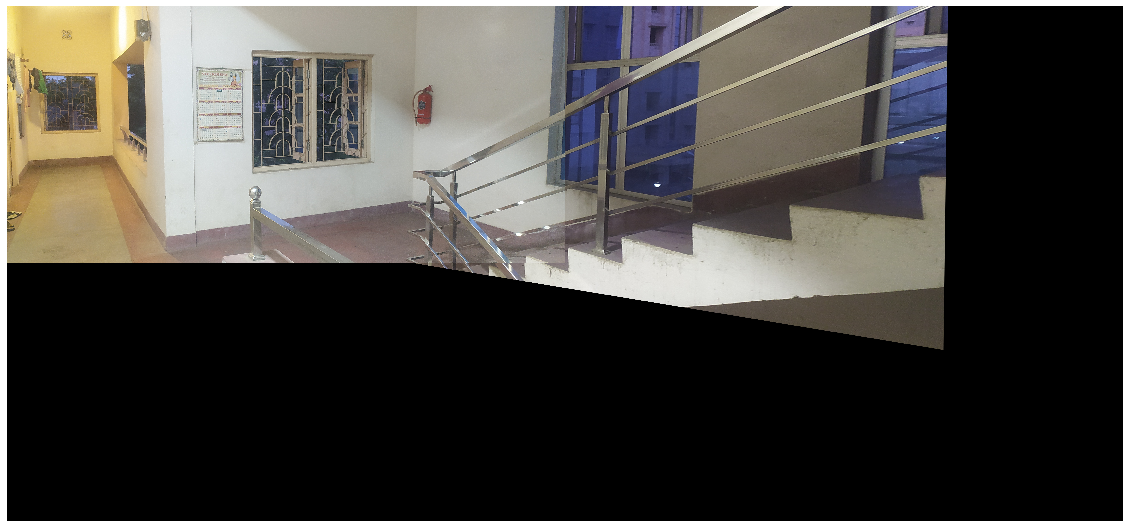

In [61]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)
plt.axis('off')
